# **Binary Classification using Neural Networks on Circular Dataset**

 ## **Introduction:**

Binary classification is a fundamental problem in machine learning where the objective is to classify data samples into one of two categories. Artificial Neural Networks (ANNs) provide a powerful framework for modeling both linear and nonlinear relationships in data.

In this assignment, a circular binary classification dataset is used, consisting of two-dimensional feature points distributed in concentric circular patterns. Such data is non-linearly separable, making it unsuitable for simple linear classifiers. Neural networks with multiple layers and nonlinear activation functions are therefore employed to learn effective decision boundaries.

## **Objectives:**

- To load and inspect the given dataset.

- To preprocess and visualize the data.

- To build, train, and evaluate multiple ANN architectures using PyTorch.

- To compare different models based on performance.

- To visualize decision boundaries.

- To draw meaningful conclusions from experimental results.

### 1. Import Required Libraries:


- torch and torch.nn: used to build and train neural networks.

- pandas: for loading and analyzing datasets.
 
- numpy: for numerical operations.
 
- matplotlib: for visualization.
 
- sklearn: for splitting training and testing data.

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(42)  # ensures reproducibility

### 2. Data Retrieval & Inspection:

2.1 Loading the Dataset:

The dataset circles_binary_classification.csv is loaded using the pandas library. Basic inspection is performed using the head(), describe(), and info() functions to understand the structure, statistical properties, and data types.

2.2 Observations:

- The dataset consists of two input features: X1 and X2.
 
- The target variable is label, indicating binary class membership.
 
- No missing values are observed.

- Feature values are continuous and suitable for neural network training.

In [3]:
df = pd.read_csv("circles_binary_classification.csv")
df.head()
df.describe()
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   label   1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


### 3. Data Cleaning & Feature Engineering:


3.1 Data Cleaning:

Since the dataset does not contain missing or corrupted values, no extensive cleaning is required.

3.2 Feature and Label Separation:

The dataset is separated into:

Feature matrix (X): Columns X1 and X2

Target vector (y): Column label

The extracted arrays are converted into PyTorch tensors using appropriate data types (float32) for compatibility with neural network operations.

In [4]:
df.isnull().sum()
# Extract features and labels
X = df[['X1', 'X2']].values
y = df['label'].values

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


### 4. Data Visualization:

4.1 Scatter Plot Visualization:

A scatter plot of X1 versus X2 colored by class label is used to visualize the dataset distribution.

Observations:

- Data points form concentric circular patterns.
 
- Classes are non-linearly separable.
 
- Linear classifiers would struggle to correctly classify this dataset.

- This visualization motivates the need for deep neural networks with nonlinear activation functions.

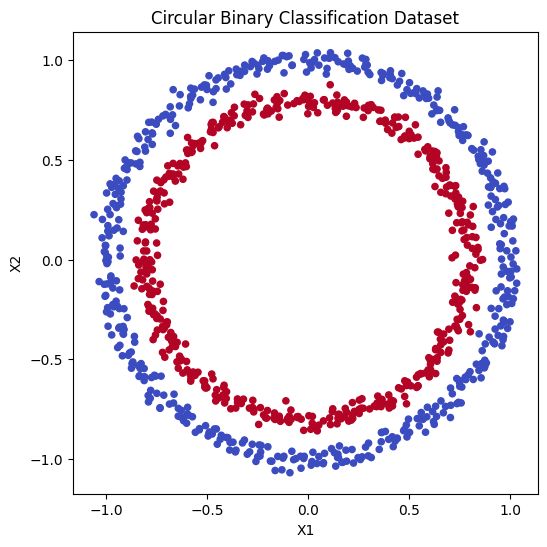

In [5]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=20)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circular Binary Classification Dataset")
plt.show()


### 5. Train–Test Split:

5.1 Dataset Splitting Strategy:

The dataset is divided into:

Training set: 80%

Testing set: 20%

A fixed random seed (random_state = 42) ensures reproducibility of results.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


torch.Size([800, 2]) torch.Size([200, 2])


### 6. Device & Tensor Handling:

6.1 Device-Agnostic Programming:

The implementation automatically selects:

- GPU (CUDA) if available

- CPU otherwise

This ensures that the code is portable across different hardware environments.

6.2 Tensor Transfer:

All tensors are moved to the selected device to ensure computational consistency and efficiency.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


Using device: cpu


### 7. Model Architectures:
Model V0: Simple Linear Network

In [8]:
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2,5),
            nn.Linear(5,1)
        )
    def forward(self, x):
        return self.layers(x)


Explanation:
This is a shallow network without nonlinear activation, so it behaves almost like a linear classifier.

Model V1: Deeper Linear Network

In [9]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2,15),
            nn.Linear(15,15),
            nn.Linear(15,1)
        )
    def forward(self, x):
        return self.layers(x)


Explanation:
More neurons increase learning capacity but still lacks non-linearity.

Model V2: Deep Nonlinear Network

In [10]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
    def forward(self, x):
        return self.layers(x)


Explanation:
This network includes ReLU activation, allowing it to learn complex nonlinear decision boundaries.

### 8. Loss Function, Optimizer & Accuracy Metric:

In [11]:
loss_fn = nn.BCEWithLogitsLoss()


Explanation:
This loss function combines sigmoid activation + binary cross entropy, improving numerical stability.

In [12]:
def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100


### 9. Training & Evaluation Loop:

In [13]:
def train_and_test_loop(model, loss_fn, optimizer, X_train, y_train, X_test, y_test, epochs):

    for epoch in range(epochs):

        model.train()

        logits = model(X_train).squeeze()
        loss = loss_fn(logits, y_train)

        preds = torch.round(torch.sigmoid(logits))
        acc = accuracy_fn(y_train, preds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_loss = loss_fn(test_logits, y_test)

            test_preds = torch.round(torch.sigmoid(test_logits))
            test_acc = accuracy_fn(y_test, test_preds)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Train Acc: {acc:.2f}% | Test Acc: {test_acc:.2f}%")


Explanation:

This loop:

- Performs forward pass
 
- Computes loss
 
- Updates weights using backpropagation

- Evaluates model performance

### 10. Training Models:

In [14]:
model0 = ModelV0().to(device)
optimizer = torch.optim.SGD(model0.parameters(), lr=0.1)
train_and_test_loop(model0, loss_fn, optimizer, X_train, y_train, X_test, y_test, epochs=100)

model1 = ModelV1().to(device)
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)
train_and_test_loop(model1, loss_fn, optimizer, X_train, y_train, X_test, y_test, epochs=1000)

model2 = ModelV2().to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)
train_and_test_loop(model2, loss_fn, optimizer, X_train, y_train, X_test, y_test, epochs=1000)


Epoch 0 | Train Loss: 0.6957 | Train Acc: 50.00% | Test Acc: 50.00%
Epoch 10 | Train Loss: 0.6940 | Train Acc: 50.00% | Test Acc: 50.00%
Epoch 20 | Train Loss: 0.6934 | Train Acc: 46.00% | Test Acc: 48.50%
Epoch 30 | Train Loss: 0.6932 | Train Acc: 49.00% | Test Acc: 47.50%
Epoch 40 | Train Loss: 0.6931 | Train Acc: 49.50% | Test Acc: 46.50%
Epoch 50 | Train Loss: 0.6931 | Train Acc: 50.38% | Test Acc: 46.50%
Epoch 60 | Train Loss: 0.6931 | Train Acc: 50.50% | Test Acc: 46.50%
Epoch 70 | Train Loss: 0.6930 | Train Acc: 50.50% | Test Acc: 46.50%
Epoch 80 | Train Loss: 0.6930 | Train Acc: 50.75% | Test Acc: 46.50%
Epoch 90 | Train Loss: 0.6930 | Train Acc: 50.38% | Test Acc: 46.50%
Epoch 0 | Train Loss: 0.6942 | Train Acc: 50.25% | Test Acc: 56.50%
Epoch 10 | Train Loss: 0.6938 | Train Acc: 50.00% | Test Acc: 51.50%
Epoch 20 | Train Loss: 0.6935 | Train Acc: 49.88% | Test Acc: 52.50%
Epoch 30 | Train Loss: 0.6934 | Train Acc: 49.50% | Test Acc: 53.50%
Epoch 40 | Train Loss: 0.6932 | Trai

### 11. Decision Boundary Visualization:

In [15]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    with torch.no_grad():
        probs = torch.sigmoid(model(grid)).reshape(xx.shape).cpu()

    plt.contourf(xx, yy, probs, cmap="coolwarm", alpha=0.6)
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu(), cmap="coolwarm", edgecolors='k')
    plt.show()


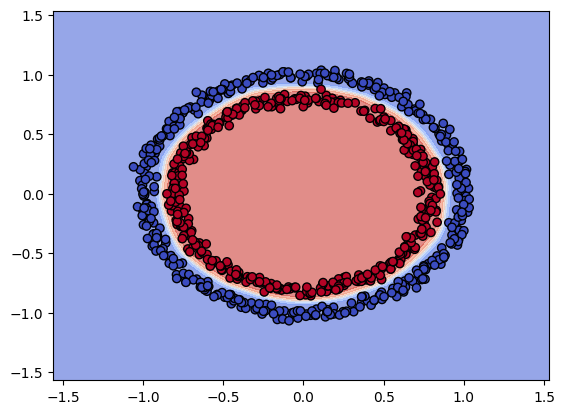

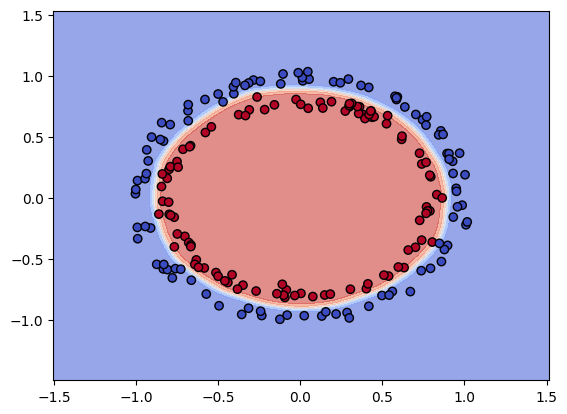

In [16]:
plot_decision_boundary(model2, X_train, y_train)
plot_decision_boundary(model2, X_test, y_test)


## **Discussion:**

ModelV0 failed due to its linear nature.

ModelV1 improved slightly but still struggled.

ModelV2 achieved highest accuracy, successfully learning circular decision boundaries.

This confirms that deep nonlinear networks are essential for solving non-linearly separable problems.

## **Conclusion:**

This assignment demonstrated the application of artificial neural networks for solving a nonlinear binary classification problem. Different ANN architectures were implemented and compared. Shallow linear models were unable to accurately classify the circular dataset. However, the deep neural network incorporating ReLU activation functions achieved significantly better performance by learning complex nonlinear patterns. The experiment highlights the importance of network depth, nonlinearity, and proper training strategies in solving real-world classification problems. The results validate the effectiveness of deep learning models for complex decision boundary learning.